(3, 4000)
[2, 0, 1]


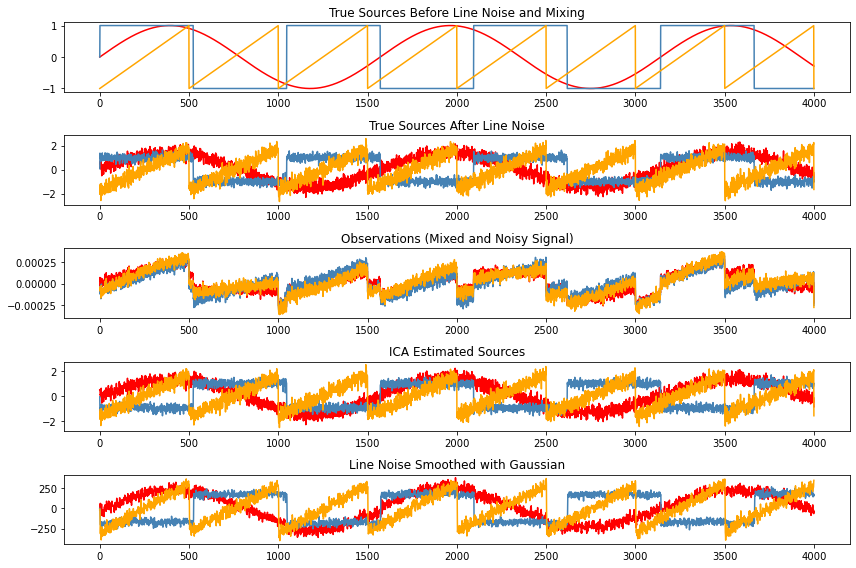

In [1]:
# From: Andac Demir
# Date: September 16 2017

# Description: This code is an implementation of fast and robust ICA with extended 
# infomax algorithm as proposed by Aapo Hyvarinen.
   
import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt


# STEP 1:
# Simulate independent signals:
np.random.seed(0)  # set seed for reproducible results
n_samples = 4000
time = np.linspace(0, 8, n_samples)
dimension = 3 # Number of independent signals to be analyzed, a priori
# A sinusoidal, a sawtooth and a square signal were generated for simulation
s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: sawtooth signal

# STEP 2:
# Concatenate the three data arrays together as the source signals:
# The shape of S is 4000 rows and 3 columns
S = np.c_[s1, s2, s3]
# Add noise drawing random samples from a Gaussian(normal) distribution:
S_noisy = S + 0.2 * np.random.normal(size=S.shape)
S_noisy /= S.std(axis=0)  # Standardize data


# STEP 3:
# Mix data with matrix A that is randomly generated:
# each entry is from uniform[0,1),
# A is 3 by 3 since there are 3 signals to analyze 
A = 0.0001*np.random.rand(dimension,dimension)
# Generate the mixed and contaminated signals
X = np.dot(A,S_noisy.T)
print(X.shape)
observations = X.T


# STEP 4:
# Remove mean
# Set axis = 1 to take the mean of each row
mean = np.mean(X, axis = 1)
# Change the dimension of the mean to a row vector of dimension*1
mean = np.reshape(mean,(len(mean),1))
ones = np.ones((1,n_samples))
# Create a matrix full of mean values for each row
meanMatrix = np.dot(mean,ones)
# Find the zero mean matrix of X
X = X - meanMatrix


# STEP 5:
# Whitening:
# This computes the covariance matrix of mean subtracted X. 
# Each row will be a variable and each column will be an observation.
covMatrix = np.cov(X)
# This provides the singular value decomposition of the covariance matrix.
# SVD is the generalization of the eigendecomposition of a positive semidefinite
# normal matrix.
U,d,V = np.linalg.svd(covMatrix, full_matrices=False)
V = V.T
# Obtaining first 3 (number of independent signals) entries
d = d[:dimension]
# Creating a row vector from the elements of d along the diagonal
D = np.diag(d)
# Obtaining 3 (number of independent signals) columns of singular eigenvectors 
E = U[:,:dimension]
# Computation of the whitening matrix D^(-1/2)*E.T
whiteningMatrix = np.dot(np.linalg.inv(np.sqrt(D)),E.T)
# whitenedMatrix is the whitened signal matrix
whitenedMatrix = np.dot(whiteningMatrix,X)


# STEP 6:
# Implement Fast Independent Component Analysis:
# Intialize the demixing matrix W:
W = np.random.rand(dimension,dimension)
# Store the estimated demixing w vectors in B
B = np.zeros((dimension,n_samples))
convergence = 1e-7;
for count in range(dimension):
    # w is a column of W
    w = W[:,count].reshape(dimension,1)
    # This represents the previous w during the 1000 iterations below
    wOld = np.zeros((dimension,1))
    
    for i in range(1,1001):
        # Orthogonalizing the projection
        w = w - np.dot(np.dot(B,B.T),w) 
        # Normalize w
        w = np.divide(w,np.linalg.norm(w))

        # If it is converged, quit
        if np.linalg.norm(w-wOld) < convergence or np.linalg.norm(w+wOld) < convergence:
            # To convert w from shape(2,1) to (2,)
            B[:,count] = w.reshape(dimension)
            W[count,:] = np.dot(w.T,whiteningMatrix)
            break
        # Update wOld
        wOld = w
        hypTan = np.tanh(np.dot(whitenedMatrix.T,w))
        w = np.divide((np.dot(whitenedMatrix,hypTan) - np.dot(np.sum(1 - np.square(hypTan)).T, w)), n_samples)
        w = np.divide(w,np.linalg.norm(w))


# STEP 7:
# Add the mean back:
uncontaminated = (np.dot(W,X) + np.dot(np.dot(W,mean),np.ones((1,n_samples)))).T
# Plotting the uncontaminated signal like above, it was observed that the signal
# was upside down compared to the original.
# By multiplying the matrix "uncontaminated" signals with -1, the signals can
# be flipped upside down, since they are zero mean.

# STEP 8:
# Smooth the unmixed ICA signal by convolving with the Gaussian Filter:
variance = 0.65;
size = 6; # If size is 5, the function creates a Gaussian Kernel size 5x5
def GaussianKernel(variance,size):
    kernel = np.zeros((size,size))
    for i in range(math.ceil(-size/2),math.ceil(size/2)):
        for j in range(math.ceil(-size/2),math.ceil(size/2)):
            kernel[i,j] = (1/(2*np.pi*variance))*np.exp(-(i^2+j^2)/(2*variance))
    return kernel

kernel = GaussianKernel(variance,size) 
# Convolve with the Gaussian Kernel to smooth the noise:
smoothed = signal.convolve(uncontaminated, kernel, mode='same')


# STEP 9:
##"uncontaminated" is a matrix with rows = nSamples and columns = dimension
#One of the drawbacks of the ICA approach is that the order of signals unmixed
#and artifacts removed is different than the order of input EEG signals. 
#This applies the nearest neighbor approach to find the EEG input signal that corresponds
#to the unmixed signal with the helper function euclidianDistance:
def euclideanDist(vec1, vec2, dimension):
    distance = 0
    #Normalize the vectors:
    vec1 = vec1/sum(vec1)
    vec2 = vec2/sum(vec2)
    for i in range(dimension):
        distance += pow((vec1[i] - vec2[i]), 2)
    return math.sqrt(distance)

def getNearestNeighbor(rawData, processedData, dimension):
    neighbors = []
    for i in range(dimension):
        distances = []
        for ii in range(dimension):
            distance = euclideanDist(rawData[:,i], processedData[:,ii], dimension)
            distances.append(distance)
        neighbors.append(distances.index(min(distances)))
    return neighbors
neighbors = getNearestNeighbor(S,uncontaminated,dimension)
print(neighbors)

uncontaminated_corrected = np.zeros((n_samples,dimension))
smoothed_corrected = np.zeros((n_samples,dimension))
for i in range(dimension):
    uncontaminated_corrected[:,i] = uncontaminated[:,neighbors[i]]
uncontaminated = uncontaminated_corrected
del uncontaminated_corrected
for i in range(dimension):
    smoothed_corrected[:,i] = smoothed[:,neighbors[i]]
smoothed = smoothed_corrected
del smoothed_corrected

# STEP 9:
# Plot your results:
plt.figure(figsize=(12, 8))
models = [S, S_noisy, observations, uncontaminated, smoothed]
names = ['True Sources Before Line Noise and Mixing',
         'True Sources After Line Noise',
         'Observations (Mixed and Noisy Signal)',
         'ICA Estimated Sources',
         'Line Noise Smoothed with Gaussian'
         ]
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(5, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.tight_layout()
plt.show()